Once force analysis for full rotation of crank is over, obtain input torque T12 with respect to all crank angles and also average input torque Tavg. The reason of using numpy array is for using standard mean function instead of writing user-defined mean function.

In [506]:
from forceloop import *

T12 = np.array(T12)
Tavg = np.mean(T12)

print(Tavg)

-116.21333278898679


Let's plot input torque with respect to crank angles.

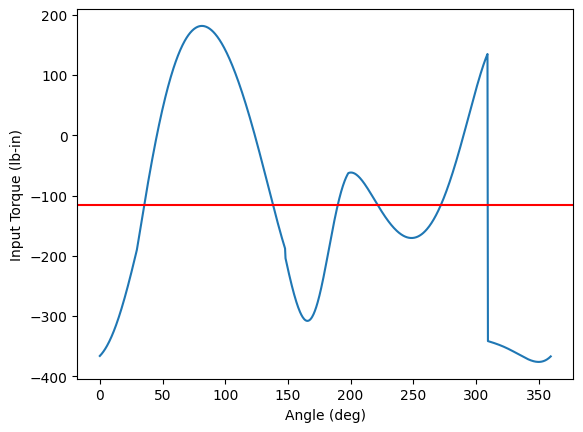

In [507]:
fig = plt.figure()
# ax.ticklabel_format(useOffset=False)
plt.ticklabel_format(style='plain', useOffset=False, axis='y') 
plt.plot(Theta_deg, T12)
plt.xlabel('Angle (deg)')
plt.ylabel('Input Torque (lb-in)')
plt.axhline(y = Tavg, color = 'r', linestyle = '-') 
plt.show()

Total area between the input torque (blue) and mean input torque (red) is the work required to run the mechanism.

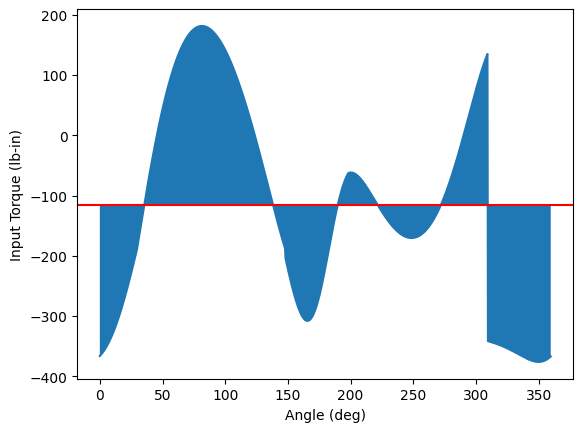

In [508]:
plt.plot(Theta_deg, T12)
plt.xlabel('Angle (deg)')
plt.ylabel('Input Torque (lb-in)')
plt.fill_between(Theta_deg, T12, Tavg)
plt.axhline(y = Tavg, color = 'r', linestyle = '-') 
plt.show()

Let's calculate the area with respect to crank angle.

In [509]:
areas = []
dtheta = 2 * pi / reso
current = 0
for T in T12:
    area = (Tavg - T) * dtheta
    current += area
    areas.append(current)

![](flywheel.png)

A flywheel is needed to smooth out the motor torque $T_M$. From Newton's second law,

$$
T_M - T_L = I\alpha
$$

where, $T_L$ is the torque required to run the mechanism, $I$ is moment of inertia of the shaft and flywheel together and $\alpha$ is the angular acceleration of the shaft. The equation implies that the excess torque $T_M - T_L$ will be used for the flywheel.

It is desired to have motor torque as constant as possible. Therefore, we set motor torque to the mean input torque $T_M = T_\text{avg}$.

Let's write angular acceleration with respect to crank angle using chain rule.

$$
\alpha = \frac{d\omega}{dt} = \frac{d\omega}{d\theta}\frac{d\theta}{dt} = \omega\frac{d\omega}{d\theta}
$$

Substitution yields

$$
T_\text{avg} - T_L = I\omega\frac{d\omega}{d\theta}
$$

Separation the variables ($\theta$ and $\omega$) yields

$$
(T_\text{avg} - T_L)d\theta = I\omega d\omega
$$

Integration between $\omega_\text{min}$ and $\omega_\text{max}$ yields

$$
\int_{\theta @\omega_\text{min}}^{\theta @\omega_\text{max}} (T_\text{avg} - T_L)d\theta = \int_{\omega_\text{min}}^{\omega_\text{max}} I\omega d\omega = \frac{I}{2}(\omega_\text{max}^2 - \omega_\text{min}^2)
$$

By integration between $\omega_\text{min}$ and $\omega_\text{max}$, right hand side of the equation, which represents the maximum kinetic energy of the flywheel, is maximized. With the given boundaries, the left hand side of the equation is also maximized.

In order to determine the extreme values, let's plot the area with respect to crank angles, that is,

$$
\int_{0}^{\theta} (T_\text{avg} - T_L)d\theta
$$

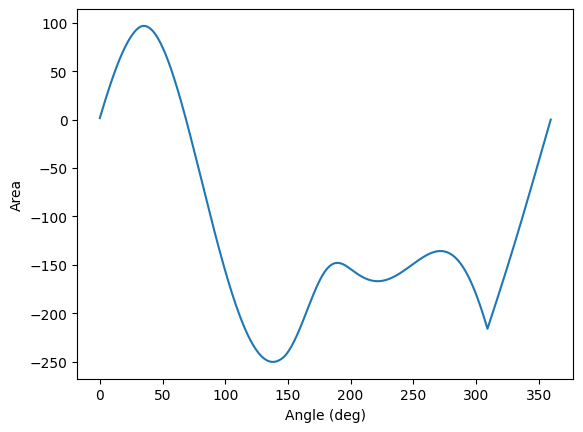

In [510]:
plt.plot(Theta_deg, areas)
plt.xlabel('Angle (deg)')
plt.ylabel('Area')
plt.show()

We are looking for the area for which between $\omega_\text{min}$ and $\omega_\text{max}$

$$
\int_{\theta @\omega_\text{min}}^{\theta @\omega_\text{max}} (T_\text{avg} - T_L)d\theta = \int_{0}^{\theta @\omega_\text{max}} (T_\text{avg} - T_L)d\theta - \int_{0}^{\theta @\omega_\text{min}} (T_\text{avg} - T_L)d\theta 
$$

Therefore, the peak minus the dip in the figure is the maximum kinetic energy of the flywheel. Let's get the angles that correspond to minimum and maximum shaft speeds, that is, $\theta @\omega_\text{min}$ and $\theta @\omega_\text{max}$.

In [511]:
min_index = areas.index(min(areas))
max_index = areas.index(max(areas))

print('theta_min_speed:', round(Theta_deg[min_index]), 'degree')
print('theta_max_speed:', round(Theta_deg[max_index]), 'degree')

theta_min_speed: 138 degree
theta_max_speed: 35 degree


Remember that

$$
\int_{\theta @\omega_\text{min}}^{\theta @\omega_\text{max}} (T_\text{avg} - T_L)d\theta = \frac{I}{2}(\omega_\text{max}^2 - \omega_\text{min}^2)
$$

Let's get moment of inertia of the flywheel and the shaft.
Let's expand the right hand side.

$$
\frac{I}{2}(\omega_\text{max}^2 - \omega_\text{min}^2) = \frac{I}{2}(\omega_\text{max} + \omega_\text{min})(\omega_\text{max} - \omega_\text{min})
$$

Defining average speed as

$$
\omega_\text{avg} = \frac{\omega_\text{max} + \omega_\text{min}}{2}
$$

and fluction in speed as

$$
Fl = \omega_\text{max} - \omega_\text{min}
$$

we write

$$
\frac{I}{2}(\omega_\text{max}^2 - \omega_\text{min}^2) = I\omega_\text{avg}Fl
$$

Note that, the average speed definition is an approximation because speed distribution is seldom even. In this example, speed of the crank is given as constant $\omega_2=25$ rad/s. The system including the flywheel cannot provide constant speed but fluctuation in speed. We desire the average speed of the shaft to be equal to the input speed, therefore, $\omega_{avg} = \omega_2$.

Also let's define coefficient of fluction as

$$
k = \frac{Fl}{\omega_\text{avg}}
$$

Therefore,

$$
\frac{I}{2}(\omega_\text{max}^2 - \omega_\text{min}^2) = Ik\omega_\text{avg}^2
$$

Moment of inertia is

$$
I = \frac{\int_{\theta @\omega_\text{min}}^{\theta @\omega_\text{max}} (T_\text{avg} - T_L)d\theta}{k\omega_\text{avg}^2}
$$

Let's define $k=0.05$ which means fluctuation in speed is 5% of the (approximate) average speed.

In [ ]:
# numerator
theregion= 0
for T in T12[min(max_index,min_index):max(max_index,min_index)]:
    theregion += (T - Tavg) * dtheta

# set average speed to desired crank speed.
omega_avg = omega2

k = 0.05
# k = 1.5

# moment of inertia of the flywheel and the shaft.
I = theregion / k / omega_avg ** 2

print(I)

11.100137583950062


We know the variation in speed and even relative speed difference for each crank angle. However, absolute speeds are yet to be determined. Let's use fluctuation and average speed definitions

$$
Fl = \omega_\text{max} - \omega_\text{min}
$$

$$
\omega_\text{avg} = \frac{\omega_\text{max} + \omega_\text{min}}{2}
$$

so that

$$
\omega_\text{min} = \frac{2\omega_\text{avg} - Fl}{2}
$$

Then, from fluction

$$
\omega_\text{max} = Fl + \omega_\text{min}
$$

In [513]:
Fl = k * omega2

min_speed = 0.5 * (2 * omega2 - Fl) 
max_speed = Fl + min_speed

print(min_speed, max_speed)

24.375 25.625


Speed at $\theta=0$ is found from

$$
\int_{0}^{\theta @\omega_\text{max}} (T_L - T_\text{avg})d\theta = \frac{I}{2}(\omega_\text{max}^2 - \omega_{\theta=0}^2)
$$

so that

$$
\omega(\theta=0) = \sqrt{\omega_\text{max}^2 - \frac{2}{I}\int_{0}^{\theta @\omega_\text{max}} (T_L - T_\text{avg})d\theta}
$$



In [514]:
areas = [i * 2 / I for i in areas]

begin_speed = sqrt(max_speed ** 2 - areas[max_index])

print(begin_speed)

25.28272912690236


Calculate speed for every crank angle with

$$
\int_{0}^{\theta} (T_\text{avg} - T_L)d\theta = \frac{I}{2}(\omega^2 - \omega_{\theta=0}^2)
$$

and

$$
\omega = \sqrt{\omega_{\theta=0}^2 + \frac{2}{I}\int_{0}^{\theta} (T_\text{avg} - T_L)d\theta}
$$

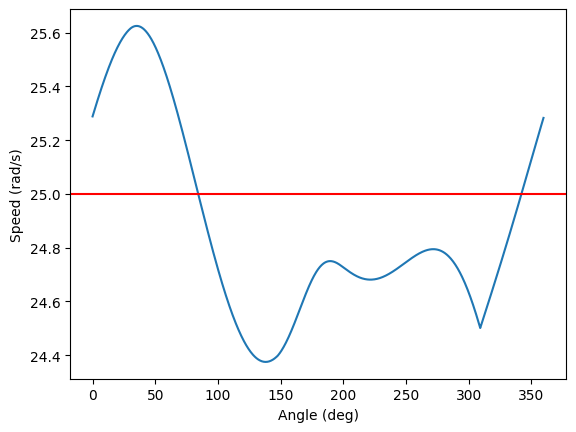

In [515]:
Omega_2 = []
for area in areas:
    Omega_2.append(sqrt(begin_speed ** 2 + area))

plt.plot(Theta_deg, Omega_2)
plt.axhline(y = omega2, color = 'r', linestyle = '-') 
plt.xlabel('Angle (deg)')
plt.ylabel('Speed (rad/s)')
plt.show()

Let's find torque to be delivered by the motor from (note that we set $T_m = T_\text{avg}$ before)

$$
\int_{0}^{\theta} (T_m - T_L)d\theta = \frac{I}{2}(\omega^2 - \omega_{\theta=0}^2)
$$

Remember that there was an approximation about average speed. Therefore, the above equation is not satisfied for the found speeds. The aim is to find $T_m$ which varies with crank angle.



$$
\int_{0}^{\theta} T_md\theta - \int_{0}^{\theta} T_Ld\theta = \frac{I}{2}(\omega^2 - \omega_{\theta=0}^2)
$$

$$
\int_{0}^{\theta} T_md\theta = \int_{0}^{\theta} T_Ld\theta + \frac{I}{2}(\omega^2 - \omega_{\theta=0}^2)
$$

aaaaa

$$
(T_m - T_L)d\theta = I\omega d\omega
$$

$$
T_m = T_L + I\omega \frac{d\omega}{d\theta}
$$

-116.97774107028124


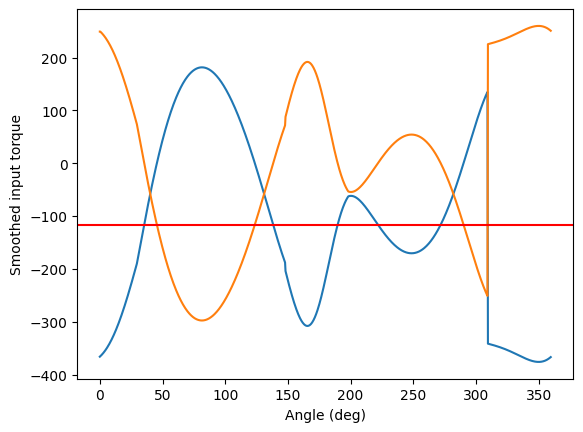

In [516]:
Tm = []
# areas = []
# current = 0
# for T in T12:
#     area = T * dtheta
#     current += area
#     areas.append(current)

for i in range(len(Theta_rad))[1:]:
    # Tm.append(T12[i] + I * Omega_2[i] * (Omega_2[i] - Omega_2[i-1]) / dtheta)
    Tm.append(I * Omega_2[i] * (Omega_2[i] - Omega_2[i-1]) / dtheta)
    # Tm.append(-I * Omega_2[i] * (Omega_2[i] - Omega_2[i-1]) / dtheta)
    # Tm.append(Tavg - I * Omega_2[i] * (Omega_2[i] - Omega_2[i-1]) / dtheta)
    # Tm.append(areas[i-1] * I / 2 - 0.5 * I * (Omega_2[i] ** 2 - Omega_2[0] ** 2))


Tm.insert(0, Tm[0])

print(T12[0] + Tm[0])

# print(Tavg, len(Theta_deg), len(Tm))

fig = plt.figure()
plt.plot(Theta_deg, T12)
# ax.ticklabel_format(useOffset=False)
plt.ticklabel_format(style='plain', useOffset=False, axis='y') 
plt.plot(Theta_deg, Tm)
plt.axhline(y = Tavg, color = 'r', linestyle = '-') 
plt.xlabel('Angle (deg)')
plt.ylabel('Smoothed input torque')
plt.show()

999 999


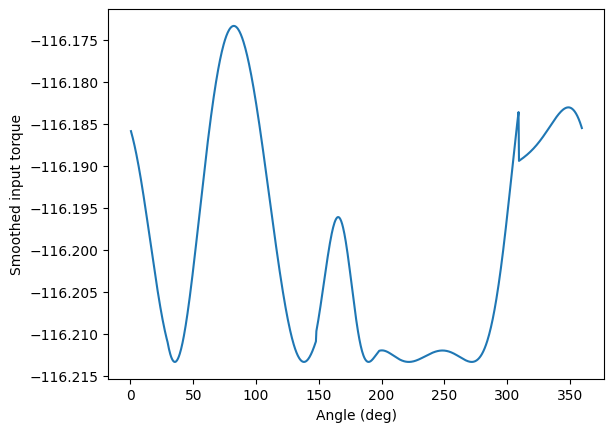

In [517]:
# Tm = []
# areas = []
# current = 0
# for T in T12:
#     area = T * dtheta
#     current += area
#     areas.append(current)

# for i in range(len(Theta_rad))[1:]:
print(len(Tm), len(T12))
for i in range(len(Theta_rad)):
    Tm[i] = Tm[i] + T12[i]
    # Tm.append(T12[i] + I * Omega_2[i] * (Omega_2[i] - Omega_2[i-1]) / dtheta)
    # Tm.append(I * Omega_2[i] * (Omega_2[i] - Omega_2[i-1]) / dtheta)
    # Tm.append(-I * Omega_2[i] * (Omega_2[i] - Omega_2[i-1]) / dtheta)
    # Tm.append(Tavg - I * Omega_2[i] * (Omega_2[i] - Omega_2[i-1]) / dtheta)
    # Tm.append(areas[i-1] * I / 2 - 0.5 * I * (Omega_2[i] ** 2 - Omega_2[0] ** 2))


# Tm.insert(0, Tm[0])

# print(Tavg, len(Theta_deg), len(Tm))

fig = plt.figure()
# plt.plot(Theta_deg, T12)
# ax.ticklabel_format(useOffset=False)
plt.ticklabel_format(style='plain', useOffset=False, axis='y') 
plt.plot(Theta_deg[1:], Tm[1:])
# plt.axhline(y = Tavg, color = 'r', linestyle = '-') 
plt.xlabel('Angle (deg)')
plt.ylabel('Smoothed input torque')
plt.show()

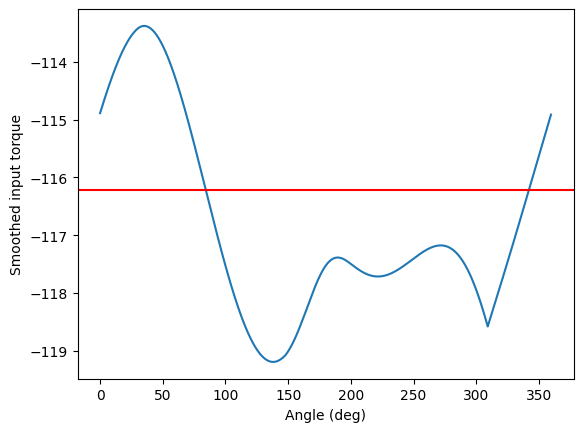

In [528]:
power = Tavg * omega_avg

Tm = []
for i in range(len(Theta_rad)):
    Tm.append(power / Omega_2[i])

fig = plt.figure()
# plt.plot(Theta_deg, T12)
# ax.ticklabel_format(useOffset=False)
plt.ticklabel_format(style='plain', useOffset=False, axis='y') 
plt.plot(Theta_deg, Tm)
plt.axhline(y = Tavg, color = 'r', linestyle = '-') 
plt.xlabel('Angle (deg)')
plt.ylabel('Smoothed input torque')
plt.show()